In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,regexp_replace, trim, split,  array_except, lit, udf, explode
from pyspark.sql.functions import expr
from nltk.corpus import stopwords
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import FloatType
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.pipeline import Pipeline

from nltk.stem import WordNetLemmatizer

#import python3
import os
import sys
from pyspark import SparkContext
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sn
import matplotlib.pyplot as plt

import nltk
import string
import re

In [2]:
spark = SparkSession.builder.appName("example").getOrCreate()
# Đọc dữ liệu từ CSV
path_to_csv = "D:\\Workspace-CTU\\Nien_luan_co_so\\Data_Movie.csv"
df = spark.read.csv(path_to_csv, header=True, inferSchema=True)

df.show()

+--------------------+--------------------+
|              review|           sentiment|
+--------------------+--------------------+
|One of the other ...|            positive|
|"A wonderful litt...| not only is it w...|
|"I thought this w...| but spirited you...|
|Basically there's...|            negative|
|"Petter Mattei's ...| power and succes...|
|"Probably my all-...| but that only ma...|
|I sure would like...|            positive|
|This show was an ...|            negative|
|Encouraged by the...|            negative|
|If you like origi...|            positive|
|"Phil the Alien i...|            negative|
|I saw this movie ...|            negative|
|"So im not a big ...| meaning most of ...|
|The cast played S...|            negative|
|This a fantastic ...|            positive|
|Kind of drawn in ...|            negative|
|Some films just s...|            positive|
|This movie made i...|            negative|
|I remember this f...|            positive|
|An awful film! It...|          

In [3]:
num_rows = df.count()

num_cols = len(df.columns)

print("Số lượng dòng:", num_rows)
print("Số lượng cột:", num_cols)


Số lượng dòng: 2000
Số lượng cột: 2


In [4]:
#hiển thị cấu trúc
df.printSchema()

df.show()


root
 |-- review: string (nullable = true)
 |-- sentiment: string (nullable = true)

+--------------------+--------------------+
|              review|           sentiment|
+--------------------+--------------------+
|One of the other ...|            positive|
|"A wonderful litt...| not only is it w...|
|"I thought this w...| but spirited you...|
|Basically there's...|            negative|
|"Petter Mattei's ...| power and succes...|
|"Probably my all-...| but that only ma...|
|I sure would like...|            positive|
|This show was an ...|            negative|
|Encouraged by the...|            negative|
|If you like origi...|            positive|
|"Phil the Alien i...|            negative|
|I saw this movie ...|            negative|
|"So im not a big ...| meaning most of ...|
|The cast played S...|            negative|
|This a fantastic ...|            positive|
|Kind of drawn in ...|            negative|
|Some films just s...|            positive|
|This movie made i...|            n

In [5]:
df = df.drop('sentiment')

In [6]:
df.show()

+--------------------+
|              review|
+--------------------+
|One of the other ...|
|"A wonderful litt...|
|"I thought this w...|
|Basically there's...|
|"Petter Mattei's ...|
|"Probably my all-...|
|I sure would like...|
|This show was an ...|
|Encouraged by the...|
|If you like origi...|
|"Phil the Alien i...|
|I saw this movie ...|
|"So im not a big ...|
|The cast played S...|
|This a fantastic ...|
|Kind of drawn in ...|
|Some films just s...|
|This movie made i...|
|I remember this f...|
|An awful film! It...|
+--------------------+
only showing top 20 rows



In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
#chuyển thành chữ thường
df = df.withColumn("review", expr("lower(review)"))

In [9]:
df.show()

+--------------------+
|              review|
+--------------------+
|one of the other ...|
|"a wonderful litt...|
|"i thought this w...|
|basically there's...|
|"petter mattei's ...|
|"probably my all-...|
|i sure would like...|
|this show was an ...|
|encouraged by the...|
|if you like origi...|
|"phil the alien i...|
|i saw this movie ...|
|"so im not a big ...|
|the cast played s...|
|this a fantastic ...|
|kind of drawn in ...|
|some films just s...|
|this movie made i...|
|i remember this f...|
|an awful film! it...|
+--------------------+
only showing top 20 rows



In [10]:
df = df.withColumn("review", regexp_replace(col("review"), "[^a-zA-Z0-9\\s]", ""))
df.show()

+--------------------+
|              review|
+--------------------+
|one of the other ...|
|a wonderful littl...|
|i thought this wa...|
|basically theres ...|
|petter matteis lo...|
|probably my allti...|
|i sure would like...|
|this show was an ...|
|encouraged by the...|
|if you like origi...|
|phil the alien is...|
|i saw this movie ...|
|so im not a big f...|
|the cast played s...|
|this a fantastic ...|
|kind of drawn in ...|
|some films just s...|
|this movie made i...|
|i remember this f...|
|an awful film it ...|
+--------------------+
only showing top 20 rows



# xóa ký tự đặc biệt

In [11]:
#xóa ký tự đặc biệt
df = df.withColumn("review_clean", regexp_replace(col("review"), "[^a-zA-Z0-9\\s]", ""))


In [12]:
df.show()

+--------------------+--------------------+
|              review|        review_clean|
+--------------------+--------------------+
|one of the other ...|one of the other ...|
|a wonderful littl...|a wonderful littl...|
|i thought this wa...|i thought this wa...|
|basically theres ...|basically theres ...|
|petter matteis lo...|petter matteis lo...|
|probably my allti...|probably my allti...|
|i sure would like...|i sure would like...|
|this show was an ...|this show was an ...|
|encouraged by the...|encouraged by the...|
|if you like origi...|if you like origi...|
|phil the alien is...|phil the alien is...|
|i saw this movie ...|i saw this movie ...|
|so im not a big f...|so im not a big f...|
|the cast played s...|the cast played s...|
|this a fantastic ...|this a fantastic ...|
|kind of drawn in ...|kind of drawn in ...|
|some films just s...|some films just s...|
|this movie made i...|this movie made i...|
|i remember this f...|i remember this f...|
|an awful film it ...|an awful f

In [13]:
#xóa khoảng trắng dư thừa
df = df.withColumn("review_clean", trim(col("review_clean")))

df.show()

+--------------------+--------------------+
|              review|        review_clean|
+--------------------+--------------------+
|one of the other ...|one of the other ...|
|a wonderful littl...|a wonderful littl...|
|i thought this wa...|i thought this wa...|
|basically theres ...|basically theres ...|
|petter matteis lo...|petter matteis lo...|
|probably my allti...|probably my allti...|
|i sure would like...|i sure would like...|
|this show was an ...|this show was an ...|
|encouraged by the...|encouraged by the...|
|if you like origi...|if you like origi...|
|phil the alien is...|phil the alien is...|
|i saw this movie ...|i saw this movie ...|
|so im not a big f...|so im not a big f...|
|the cast played s...|the cast played s...|
|this a fantastic ...|this a fantastic ...|
|kind of drawn in ...|kind of drawn in ...|
|some films just s...|some films just s...|
|this movie made i...|this movie made i...|
|i remember this f...|i remember this f...|
|an awful film it ...|an awful f

# Lemmatization

In [14]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(text)

# Chuyển hàm Lemmatization thành PySpark UDF
udf_lemmatize = udf(lemmatize, StringType())

df = df.withColumn("review_clean", udf_lemmatize(col("review_clean")))

df.show()

+--------------------+--------------------+
|              review|        review_clean|
+--------------------+--------------------+
|one of the other ...|one of the other ...|
|a wonderful littl...|a wonderful littl...|
|i thought this wa...|i thought this wa...|
|basically theres ...|basically theres ...|
|petter matteis lo...|petter matteis lo...|
|probably my allti...|probably my allti...|
|i sure would like...|i sure would like...|
|this show was an ...|this show was an ...|
|encouraged by the...|encouraged by the...|
|if you like origi...|if you like origi...|
|phil the alien is...|phil the alien is...|
|i saw this movie ...|i saw this movie ...|
|so im not a big f...|so im not a big f...|
|the cast played s...|the cast played s...|
|this a fantastic ...|this a fantastic ...|
|kind of drawn in ...|kind of drawn in ...|
|some films just s...|some films just s...|
|this movie made i...|this movie made i...|
|i remember this f...|i remember this f...|
|an awful film it ...|an awful f

# tách từ

In [15]:
#tách từ và đưa vào mảng
df = df.withColumn("review_clean", split(col("review_clean"), " "))

df.show()

+--------------------+--------------------+
|              review|        review_clean|
+--------------------+--------------------+
|one of the other ...|[one, of, the, ot...|
|a wonderful littl...|[a, wonderful, li...|
|i thought this wa...|[i, thought, this...|
|basically theres ...|[basically, there...|
|petter matteis lo...|[petter, matteis,...|
|probably my allti...|[probably, my, al...|
|i sure would like...|[i, sure, would, ...|
|this show was an ...|[this, show, was,...|
|encouraged by the...|[encouraged, by, ...|
|if you like origi...|[if, you, like, o...|
|phil the alien is...|[phil, the, alien...|
|i saw this movie ...|[i, saw, this, mo...|
|so im not a big f...|[so, im, not, a, ...|
|the cast played s...|[the, cast, playe...|
|this a fantastic ...|[this, a, fantast...|
|kind of drawn in ...|[kind, of, drawn,...|
|some films just s...|[some, films, jus...|
|this movie made i...|[this, movie, mad...|
|i remember this f...|[i, remember, thi...|
|an awful film it ...|[an, awful

# xóa các từ vô nghĩa

In [16]:
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
df = df.withColumn("review_clean", 
                   udf(lambda words: [word for word in words if word.lower() not in stop], 
                       ArrayType(StringType()))(col("review_clean")))

df.show()

+--------------------+--------------------+
|              review|        review_clean|
+--------------------+--------------------+
|one of the other ...|[one, reviewers, ...|
|a wonderful littl...|[wonderful, littl...|
|i thought this wa...|[thought, wonderf...|
|basically theres ...|[basically, there...|
|petter matteis lo...|[petter, matteis,...|
|probably my allti...|[probably, alltim...|
|i sure would like...|[sure, would, lik...|
|this show was an ...|[show, amazing, f...|
|encouraged by the...|[encouraged, posi...|
|if you like origi...|[like, original, ...|
|phil the alien is...|[phil, alien, one...|
|i saw this movie ...|[saw, movie, 12, ...|
|so im not a big f...|[im, big, fan, bo...|
|the cast played s...|[cast, played, sh...|
|this a fantastic ...|[fantastic, movie...|
|kind of drawn in ...|[kind, drawn, ero...|
|some films just s...|[films, simply, r...|
|this movie made i...|[movie, made, one...|
|i remember this f...|[remember, filmit...|
|an awful film it ...|[awful, fi

# word_count

In [18]:

def count_words(text):
    word_count = {}
    for word in text:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
    return word_count

# Chuyển hàm đếm từ thành PySpark UDF
udf_count_words = udf(count_words, "map<string,int>")

# Áp dụng UDF cho cột 'review_clean' và tạo cột mới 'word_count'
df = df.withColumn("word_count", udf_count_words(col("review_clean")))

# Mở rộng DataFrame để có một dòng cho mỗi từ và giá trị đếm
df1 = df.select( explode("word_count").alias("word", "word_count"))

# Hiển thị DataFrame sau khi áp dụng UDF
df1.show()



+------------+----------+
|        word|word_count|
+------------+----------+
|       youll|         1|
|       wholl|         2|
|   injustice|         1|
|      called|         1|
|       taste|         1|
|experimental|         1|
|     episode|         2|
|     hearted|         1|
|      guards|         1|
|      doesnt|         1|
|      skills|         1|
|       would|         1|
|         far|         1|
|      struck|         2|
| penitentary|         1|
|     muslims|         1|
|       state|         1|
|      prison|         3|
|       order|         1|
|      moreso|         1|
+------------+----------+
only showing top 20 rows



In [19]:
df1 = df1.orderBy(col("word_count").desc())

In [20]:
df1.show(25000)

+--------------------+----------+
|                word|word_count|
+--------------------+----------+
|                    |        25|
|                    |        25|
|                    |        24|
|                    |        20|
|                    |        19|
|               movie|        19|
|               mario|        18|
|               world|        18|
|               woman|        17|
|                    |        17|
|              pretty|        16|
|              amanda|        15|
|                    |        15|
|                    |        15|
|                    |        14|
|                 new|        14|
|                film|        14|
|               drugs|        14|
|                drug|        14|
|               movie|        14|
|                film|        14|
|                    |        13|
|               movie|        13|
|                bugs|        13|
|                part|        13|
|                    |        13|
|             

In [21]:
df2 = df1.groupBy('word').agg(spark_sum('word_count').alias('word_count'))

df2 = df2.orderBy(col("word_count").desc())

df2.show()

+------+----------+
|  word|word_count|
+------+----------+
| movie|      2502|
|  film|      1940|
|      |      1406|
|   one|      1307|
|  like|      1002|
|  good|       783|
| would|       667|
|   see|       649|
| story|       616|
|  even|       616|
|really|       615|
|  time|       577|
|  well|       524|
|   get|       515|
|  much|       514|
| great|       495|
|   bad|       476|
|movies|       472|
| first|       472|
|people|       462|
+------+----------+
only showing top 20 rows



# SENTIMENT ANALYSIS

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [23]:
analyser=SentimentIntensityAnalyzer()

def sentiment_pos(sentence):
    sent=analyser.polarity_scores(sentence)
    return sent['pos']

def sentiment_neg(sentence):
    sent=analyser.polarity_scores(sentence)
    return sent['neg']

def sentiment_neu(sentence):
    sent=analyser.polarity_scores(sentence)
    return sent['neu']

def sentiment_comp(sentence):
    sent=analyser.polarity_scores(sentence)
    return sent['compound']

In [24]:
sentiment_pos("this movie very bad")

0.0

In [25]:
sentiment_neg("this movie very bad")

0.558

In [26]:
sentiment_neu("this movie not bad")

0.513

In [27]:
sentiment_comp("this movie very bad")

-0.5849

In [28]:
analyser = SentimentIntensityAnalyzer()
#định nghĩa các hàm kiểm tra, positive, negative, neutral
sentiment_pos = udf(lambda sentence: analyser.polarity_scores(sentence)['pos'], FloatType())
sentiment_neg = udf(lambda sentence: analyser.polarity_scores(sentence)['neg'], FloatType())
sentiment_neu = udf(lambda sentence: analyser.polarity_scores(sentence)['neu'], FloatType())
sentiment_comp = udf(lambda sentence: analyser.polarity_scores(sentence)['compound'], FloatType())


df2 = df2.withColumn('positive', sentiment_pos('word'))
df2 = df2.withColumn('negative', sentiment_neg('word'))
df2 = df2.withColumn('neutral', sentiment_neu('word'))

# Show the new PySpark DataFrame
df2.show()

+------+----------+--------+--------+-------+
|  word|word_count|positive|negative|neutral|
+------+----------+--------+--------+-------+
| movie|      2502|     0.0|     0.0|    1.0|
|  film|      1940|     0.0|     0.0|    1.0|
|      |      1406|     0.0|     0.0|    0.0|
|   one|      1307|     0.0|     0.0|    1.0|
|  like|      1002|     1.0|     0.0|    0.0|
|  good|       783|     1.0|     0.0|    0.0|
| would|       667|     0.0|     0.0|    1.0|
|   see|       649|     0.0|     0.0|    1.0|
|  even|       616|     0.0|     0.0|    1.0|
| story|       616|     0.0|     0.0|    1.0|
|really|       615|     0.0|     0.0|    1.0|
|  time|       577|     0.0|     0.0|    1.0|
|  well|       524|     1.0|     0.0|    0.0|
|   get|       515|     0.0|     0.0|    1.0|
|  much|       514|     0.0|     0.0|    1.0|
| great|       495|     1.0|     0.0|    0.0|
|   bad|       476|     0.0|     1.0|    0.0|
|movies|       472|     0.0|     0.0|    1.0|
| first|       472|     0.0|     0

In [29]:
#áp dụng vào các đánh giá
df = df.withColumn("sentiment_pos", sentiment_pos(df["review"]))
df = df.withColumn("sentiment_neg", sentiment_neg(df["review"]))
df = df.withColumn("sentiment_neu", sentiment_neu(df["review"]))

In [30]:
df = df.withColumn("row_id", monotonically_increasing_id())

# Hiển thị DataFrame
df.show(2000)

+--------------------+--------------------+--------------------+-------------+-------------+-------------+------+
|              review|        review_clean|          word_count|sentiment_pos|sentiment_neg|sentiment_neu|row_id|
+--------------------+--------------------+--------------------+-------------+-------------+-------------+------+
|one of the other ...|[one, reviewers, ...|{youll -> 1, whol...|        0.057|        0.198|        0.746|     0|
|a wonderful littl...|[wonderful, littl...|{ -> 2, comfortin...|        0.138|        0.026|        0.836|     1|
|i thought this wa...|[thought, wonderf...|{lighthearted -> ...|        0.192|        0.104|        0.704|     2|
|basically theres ...|[basically, there...|{ -> 3, opera -> ...|        0.083|        0.137|         0.78|     3|
|petter matteis lo...|[petter, matteis,...|{offers -> 1, lov...|        0.175|          0.0|        0.825|     4|
|probably my allti...|[probably, alltim...|{midgets -> 1, te...|        0.265|        0.

#  WordCloud

In [31]:
pip install wordcloud

In [32]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
comment_words = ''
stopwords = set(STOPWORDS)

# Assuming you have a DataFrame named 'df' with a column named 'review'
for row in df.select("review").collect():
    x = str(row.review)

    tokens = x.split()

    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    for y in tokens:
        comment_words = comment_words + y + ' '

In [34]:
comment_words

'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pic

In [35]:
wordcloud=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

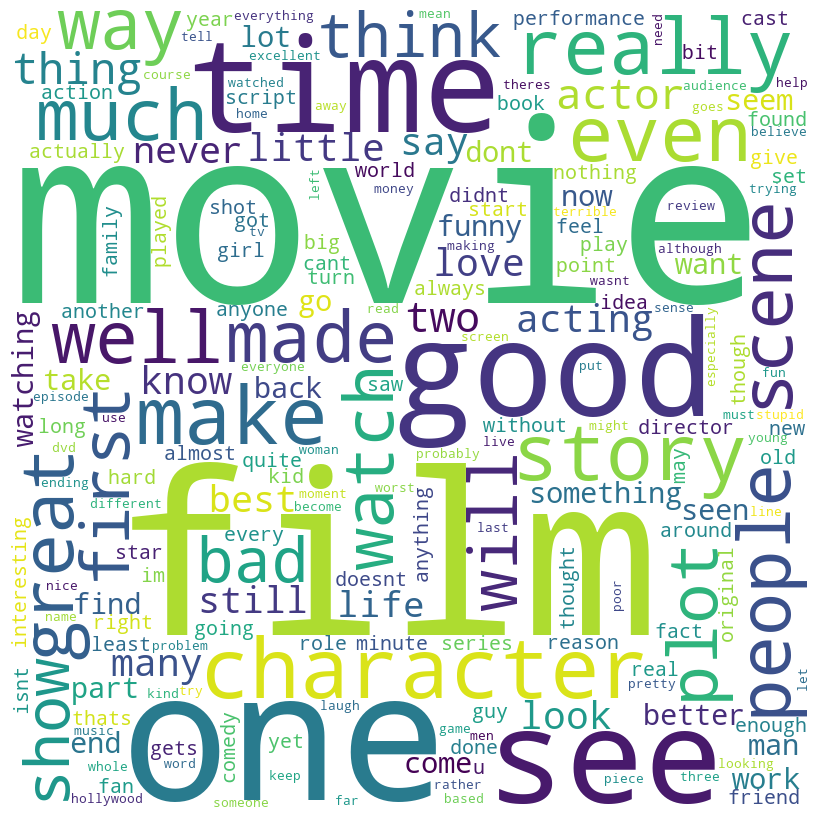

In [36]:
plt.figure(figsize = (8, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Xác định các chủ đề chính của vấn đề sử dụng thuật toán K-Means

In [37]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
df.select('review').show()

+--------------------+
|              review|
+--------------------+
|one of the other ...|
|a wonderful littl...|
|i thought this wa...|
|basically theres ...|
|petter matteis lo...|
|probably my allti...|
|i sure would like...|
|this show was an ...|
|encouraged by the...|
|if you like origi...|
|phil the alien is...|
|i saw this movie ...|
|so im not a big f...|
|the cast played s...|
|this a fantastic ...|
|kind of drawn in ...|
|some films just s...|
|this movie made i...|
|i remember this f...|
|an awful film it ...|
+--------------------+
only showing top 20 rows



In [39]:
problems_df = df.filter(col("sentiment_neu") > 0).select("review")

problems_df.show()

+--------------------+
|              review|
+--------------------+
|one of the other ...|
|a wonderful littl...|
|i thought this wa...|
|basically theres ...|
|petter matteis lo...|
|probably my allti...|
|i sure would like...|
|this show was an ...|
|encouraged by the...|
|if you like origi...|
|phil the alien is...|
|i saw this movie ...|
|so im not a big f...|
|the cast played s...|
|this a fantastic ...|
|kind of drawn in ...|
|some films just s...|
|this movie made i...|
|i remember this f...|
|an awful film it ...|
+--------------------+
only showing top 20 rows



# VECTORIZING RAW DATA: TF-IDF

In [40]:
#Chuyển đổi DataFrame từ PySpark sang Pandas DataFrame
problems_pd_df = problems_df.toPandas()

# Khởi tạo một đối tượng TfidfVectorizer từ thư viện scikit-learn.TfidfVectorizer được sử dụng để chuyển đổi văn bản thành ma trận TF-IDF,  biểu diễn tần suất xuất hiện của từng từ trong văn bản
vectorizer = TfidfVectorizer(stop_words='english')
# Áp dụng vector hóa TF-IDF lên cột "review" của Pandas DataFrame. Kết quả là ma trận spase (hiện diện cho sự thưa thớt) trong đó mỗi hàng biểu diễn một văn bản và mỗi cột biểu diễn một từ, giá trị là TF-IDF của từng từ trong văn bản.
X = vectorizer.fit_transform(problems_pd_df['review'])

In [41]:
X

<1997x22317 sparse matrix of type '<class 'numpy.float64'>'
	with 117043 stored elements in Compressed Sparse Row format>

In [42]:
#Số lượng cụm bạn muốn mô hình K-means phải phân chia dữ liệu thành.
k=3
# Phương pháp khởi tạo trung tâm cụm. 'k-means++' là một phương pháp thông minh để chọn các trung tâm ban đầu sao cho chúng cách xa nhau.
#Số lượng cụm bạn muốn phân chia dữ liệu thành, đã được đặt là 3 ở đây.
#Số lượng lần chạy thuật toán với các tập trung cụm ban đầu khác nhau. Kết quả tốt nhất sẽ được chọn.
model = KMeans(init='k-means++', n_clusters=3, n_init=10,max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='auto',     
    )
# sẽ thực hiện quá trình đào tạo mô hình K-means trên ma trận X, là ma trận TF-IDF đã được vector hóa từ dữ liệu văn bản
model.fit(X)

C:\Users\ngoth\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='auto', n_clusters=3, n_init=10)

In [43]:
#sau khi thực thi, centroids là một mảng chỉ số của các đặc trưng được sắp xếp theo độ quan trọng giảm dần cho mỗi cụm.
centroids= model.cluster_centers_.argsort()[:, ::-1]

#Phương thức này trả về danh sách tên của các đặc trưng. Các tên này tương ứng với các từ hoặc n-grams được sử dụng trong quá trình vector hóa.
features=vectorizer.get_feature_names_out()
#sau khi thực thi , features là danh sách tên của các đặc trưng. Các thông tin này có thể giúp hiểu rõ hơn về nội dung của từng cụm trong mô hình K-means

In [44]:
#với mỗi cụm, in ra 10 đặc trưng quan trọng nhất và tên của chúng. Điều này giúp hiểu rõ hơn về nội dung và chủ đề của từng cụm trong mô hình K-means
for i in range(0,3):
    print('\n\nCluster %d:' % i)
    for ind in centroids[i, :10]:
        print('\t  - %s' % features[ind])
        
#trong các cụm có thể có các từ ở đầu giống nhau có thể trọng số của từ trong các cụm đó giống nhau.
#nhưng khi xem xuống các từ kế tiếp, ví dụ như ở cụm 1 chỉ có các từ mang nghĩa tích cực như "good, great, like..."
#còn ở chụm 2 thì chứa các từ "bad, dont ..."



Cluster 0:
	  - film
	  - films
	  - just
	  - like
	  - story
	  - plot
	  - good
	  - great
	  - movie
	  - time


Cluster 1:
	  - movie
	  - film
	  - like
	  - just
	  - story
	  - good
	  - time
	  - people
	  - series
	  - great


Cluster 2:
	  - movie
	  - bad
	  - good
	  - like
	  - just
	  - really
	  - movies
	  - watch
	  - dont
	  - story


In [45]:

df_pd = df.toPandas()

In [46]:
df_pd.head()
df_pd.drop(['word_count'], axis=1)

,review,review_clean,sentiment_pos,sentiment_neg,sentiment_neu,row_id
0,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, 1, oz, e...",0.057,0.198,0.746,0
1,a wonderful little production the filming tec...,"[wonderful, little, production, , filming, tec...",0.138,0.026,0.836,1
2,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...",0.192,0.104,0.704,2
3,basically theres a family where a little boy j...,"[basically, theres, family, little, boy, jake,...",0.083,0.137,0.780,3
4,petter matteis love in the time of money is a ...,"[petter, matteis, love, time, money, visually,...",0.175,0.000,0.825,4
...,...,...,...,...,...,...
1995,feeling minnesota directed by steven baigelman...,"[feeling, minnesota, directed, steven, baigelm...",0.048,0.118,0.834,1995
1996,the cell 2000 rating 810 the cell like antz mu...,"[cell, 2000, rating, 810, cell, like, antz, mu...",0.258,0.043,0.699,1996
1997,this movie despite its list of b c and d list ...,"[movie, despite, list, b, c, list, celebs, com...",0.093,0.112,0.795,1997
1998,i loved this movie it was all i could do not t...,"[loved, movie, could, break, tears, watching, ...",0.172,0.210,0.618,1998


In [47]:
X=vectorizer.transform(df_pd.review)
df_pd['cluster']=model.predict(X)
df_pd = df_pd.drop(['word_count'], axis=1)

In [48]:
df_pd

,review,review_clean,sentiment_pos,sentiment_neg,sentiment_neu,row_id,cluster
0,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, 1, oz, e...",0.057,0.198,0.746,0,1
1,a wonderful little production the filming tec...,"[wonderful, little, production, , filming, tec...",0.138,0.026,0.836,1,1
2,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...",0.192,0.104,0.704,2,1
3,basically theres a family where a little boy j...,"[basically, theres, family, little, boy, jake,...",0.083,0.137,0.780,3,2
4,petter matteis love in the time of money is a ...,"[petter, matteis, love, time, money, visually,...",0.175,0.000,0.825,4,0
...,...,...,...,...,...,...,...
1995,feeling minnesota directed by steven baigelman...,"[feeling, minnesota, directed, steven, baigelm...",0.048,0.118,0.834,1995,1
1996,the cell 2000 rating 810 the cell like antz mu...,"[cell, 2000, rating, 810, cell, like, antz, mu...",0.258,0.043,0.699,1996,0
1997,this movie despite its list of b c and d list ...,"[movie, despite, list, b, c, list, celebs, com...",0.093,0.112,0.795,1997,0
1998,i loved this movie it was all i could do not t...,"[loved, movie, could, break, tears, watching, ...",0.172,0.210,0.618,1998,2
